In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from partition_decode.plots import continuous_pairplot
from scipy.stats import spearmanr, kendalltau

sns.set_style('white')
sns.set_context('notebook')

# Forest

In [9]:
#
algo = "forest"
dataset = "xor"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv')

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'n_estimators', 'max_depth'],
    as_index=False,
).mean()

df.head(5)

model  n_train_samples  n_estimators max_depth  rep  n_test_samples  \
0  forest           1024.0           1.0         1  1.0          8192.0   
1  forest           1024.0           1.0        10  1.0          8192.0   
2  forest           1024.0           1.0        11  1.0          8192.0   
3  forest           1024.0           1.0        12  1.0          8192.0   
4  forest           1024.0           1.0        13  1.0          8192.0   

   recurse_level  cov_scale  onehot  bootstrap  ...    IRM_h*  ACTS_h*  \
0            0.0        1.0     1.0        0.0  ...  2.000000      2.0   
1            0.0        1.0     1.0        0.0  ...  3.000000      0.0   
2            0.0        1.0     1.0        0.0  ...  2.000000      0.0   
3            0.0        1.0     1.0        0.0  ...  1.666667      0.0   
4            0.0        1.0     1.0        0.0  ...  1.666667      0.0   

   IRM_entropy  IRM_rows_mean_L2  IRM_cols_mean_L1  IRM_cols_mean_L2  \
0     0.135691          0.970199          0.500000          0.015625   
1     4.039069          0.176085          0.007463          0.000233   
2     4.234992          0.160237          0.006410          0.000200   
3     4.382711          0.149804          0.005747          0.000180   
4     4.528524          0.141440          0.005172          0.000162   

   IRM_mean_dot_product  IRM_mean_sim_entropy  n_total_leaves  \
0            963.876953              6.795780        2.000000   
1             31.750000              2.892403      134.000000   
2             26.292969              2.696480      156.000000   
3             22.990234              2.548761      174.000000   
4             20.517578              2.402947      193.333333   

   generalization_gap  
0            0.002967  
1            0.191718  
2            0.218469  
3            0.237974  
4            0.264446  

[5 rows x 30 columns]

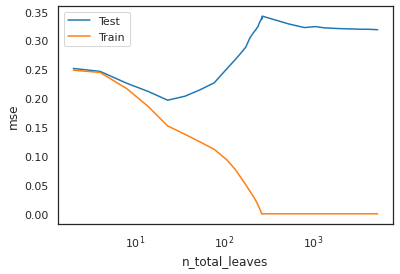

In [10]:
plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

x_var = 'n_total_leaves'
sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

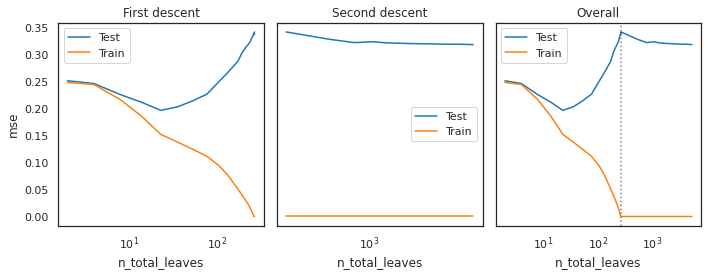

First_descent  Second_descent   Overall
generalization_gap         1.000000        1.000000  1.000000
test_mse                   0.969744        1.000000  0.975911
n_total_leaves             0.989427       -0.987879  0.690256
n_estimators                    NaN       -0.987879  0.050589
IRM_L0                     0.989427       -0.753123  0.699531
IRM_L1                          NaN       -0.785355  0.055708
IRM_L2                    -0.973075        0.854545 -0.685090
n_regions                  0.989427       -0.920749  0.691743
ACTS_L2                   -0.973075        0.924016 -0.684011
IRM_h*                    -0.865688             NaN -0.819888
ACTS_h*                   -0.636271             NaN -0.574371
IRM_entropy                0.991101       -0.951515  0.691700
IRM_rows_mean_L2          -0.973075       -0.987879 -0.796032
IRM_cols_mean_L1          -0.989432       -0.345455 -0.847614
IRM_cols_mean_L2          -0.989432       -0.345455 -0.847614
IRM_mean_dot_product      -0.971174        0.987879 -0.681954
IRM_mean_sim_entropy      -0.991101       -0.963636 -0.992308

In [11]:
## Correlation variables
corr_vars = [
    'generalization_gap', test_error,
    'n_total_leaves', 'n_estimators',
    'IRM_L0', 'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'n_total_leaves'
# U_argmin = 700
interp = df[df['n_estimators']==1]['n_total_leaves'].max()

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
# Join ascent/second descent y-axes
# axes[1].get_shared_y_axes().join(axes[1], axes[2])

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        # (df[x_var] >= U_argmin) & (df[x_var] <= interp),
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

# axes[3].axvline(df[df[x_var] == U_argmin][x_var].iloc[0], ls=':', c='grey', label='U argmin')
axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
axes[0].set_ylabel(metric)
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

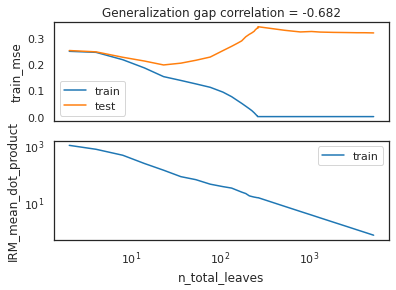

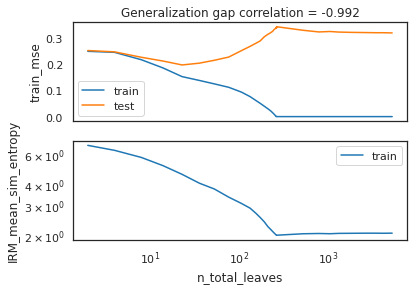

In [13]:
plot_vars = [
#     'IRM_L0', 'IRM_L1', 'IRM_L2', 'n_regions',
#     'IRM_entropy',
#     'IRM_rows_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

plot_df = df
x_var = 'n_total_leaves'

for var in plot_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    plt.yscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

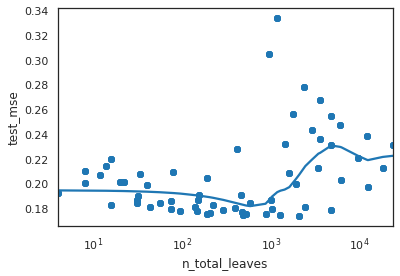

In [12]:
sns.set_style('white')
sns.set_context('notebook')
sns.regplot(data=df, x='n_total_leaves', y=test_error, lowess=True)
plt.xscale('log')
plt.show()

## Plot all, colored by generalization gap

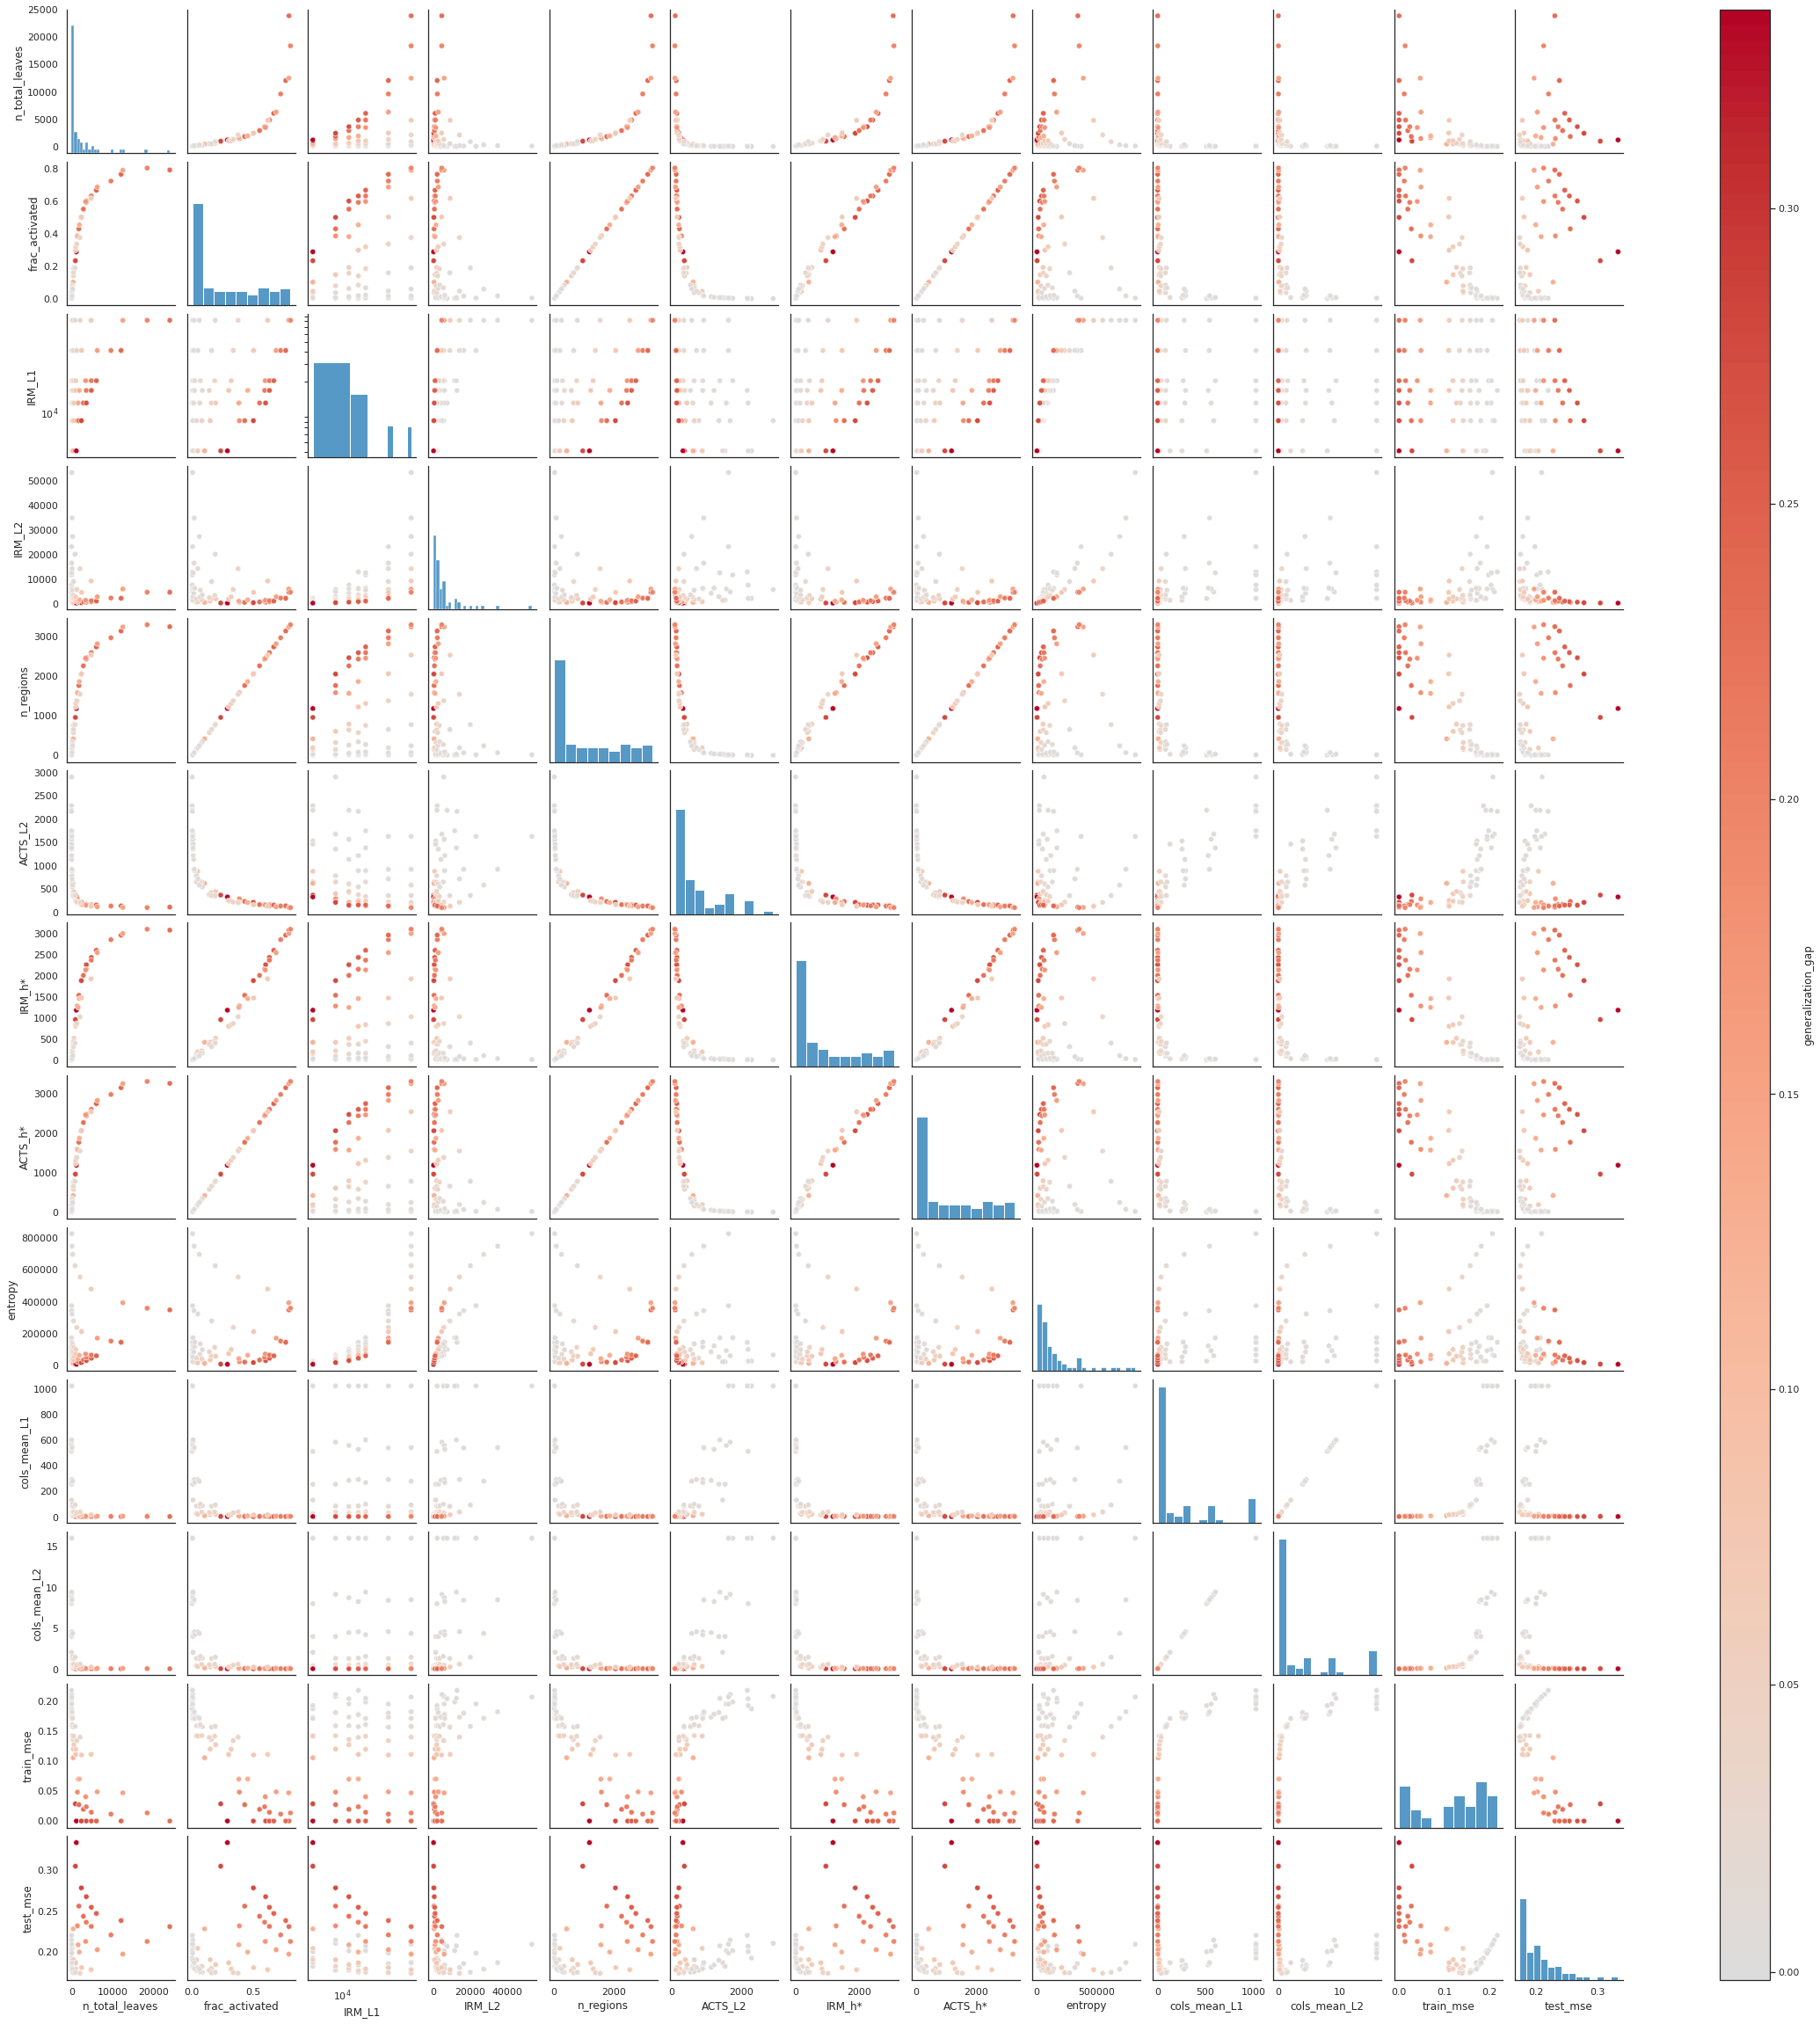

In [6]:
sns.set_context('notebook')
hue = 'generalization_gap'
variables = [
    # 'n_estimators', 'max_depth',
    'n_total_leaves', 'frac_activated',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'entropy',
    # 'rows_mean_L1', 'rows_mean_L2',
    'cols_mean_L1', 'cols_mean_L2',
    train_error, test_error
]
g = continuous_pairplot(
    df, vars=variables,
    hue=hue,
)
g.axes[2, 0].set_yscale('log')
g.axes[0, 2].set_xscale('log')
plt.savefig('./figures/rf_continuous_pairplot.pdf')
plt.show()

## Dynamics of complexity measures

IRM_L1
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


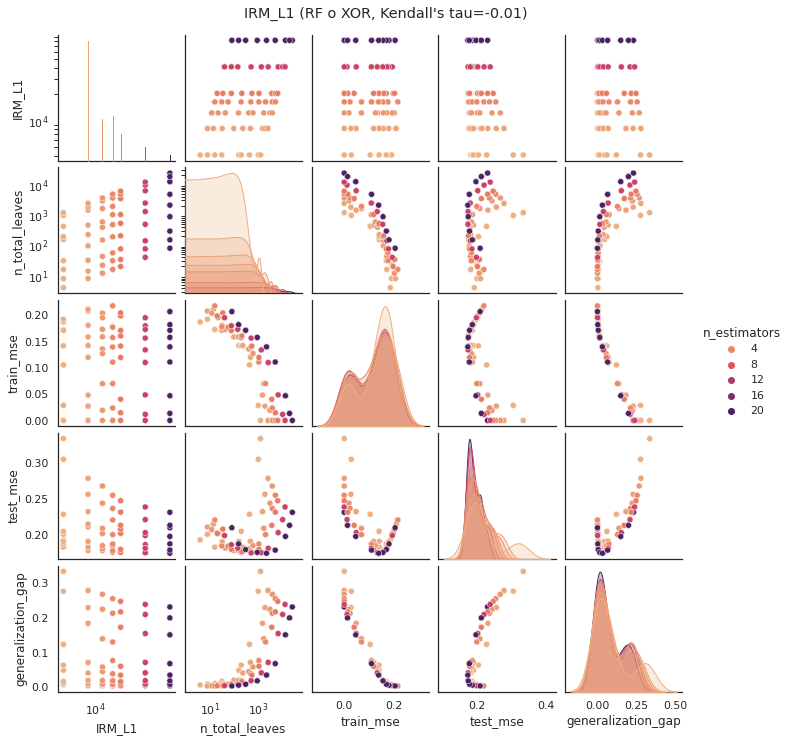

IRM_L2
##################################################


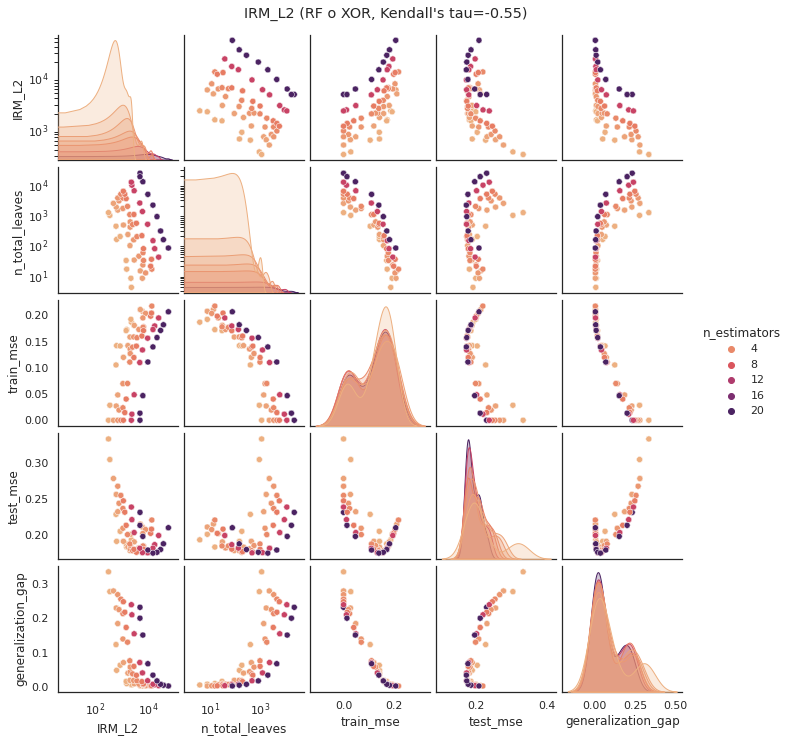

n_regions
##################################################


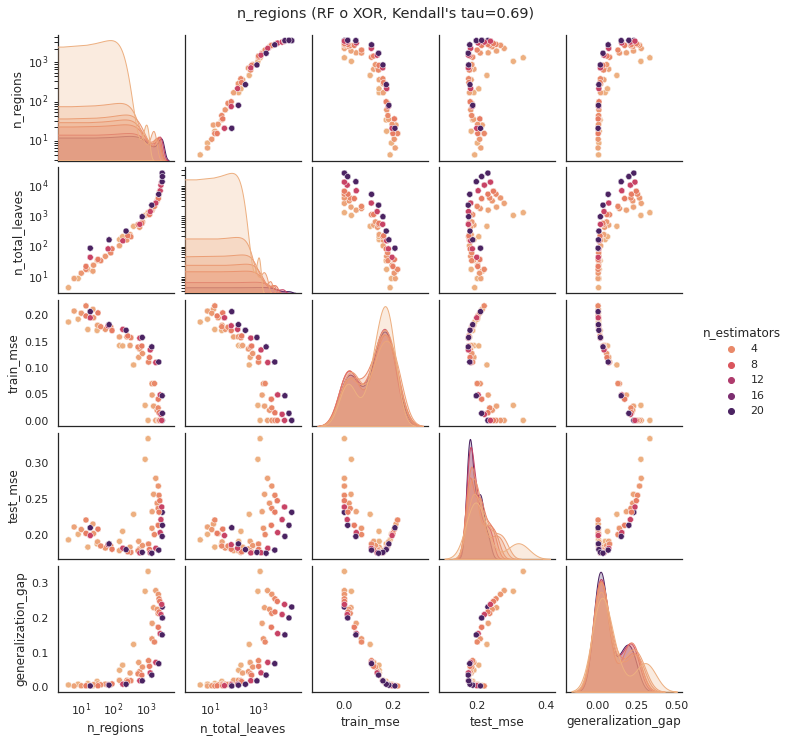

ACTS_L2
##################################################


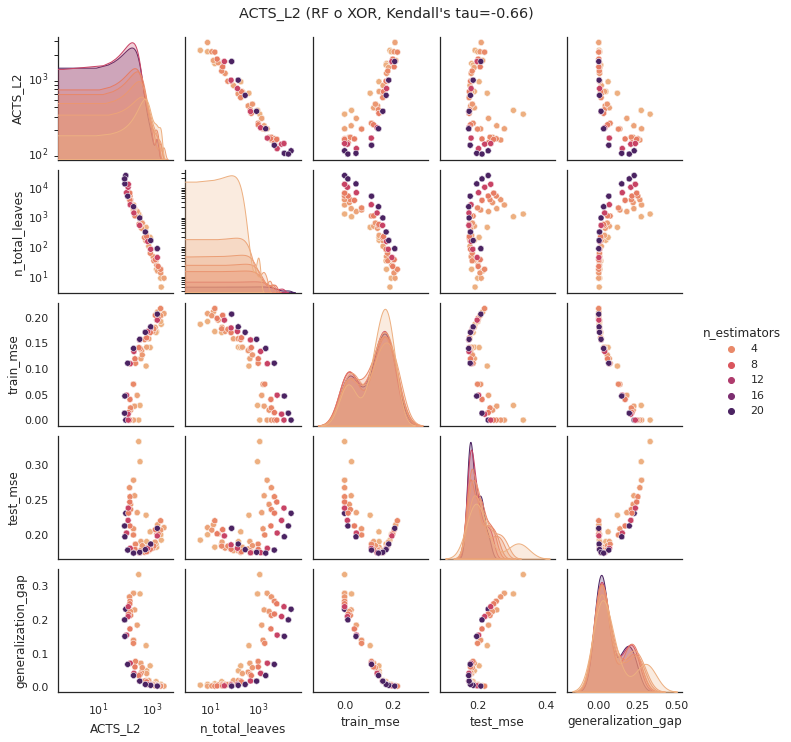

IRM_h*
##################################################


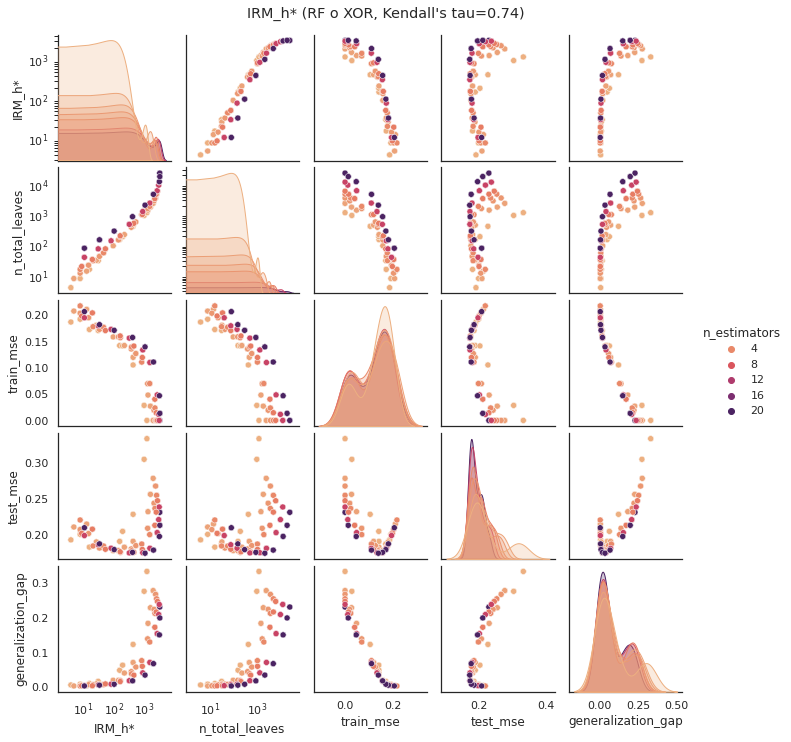

ACTS_h*
##################################################


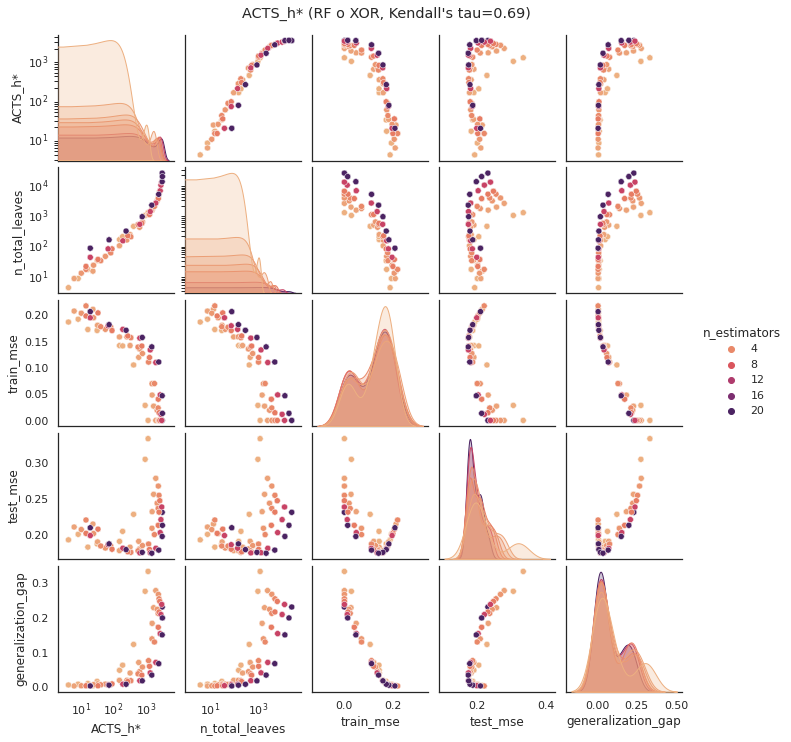

rows_mean_L1
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

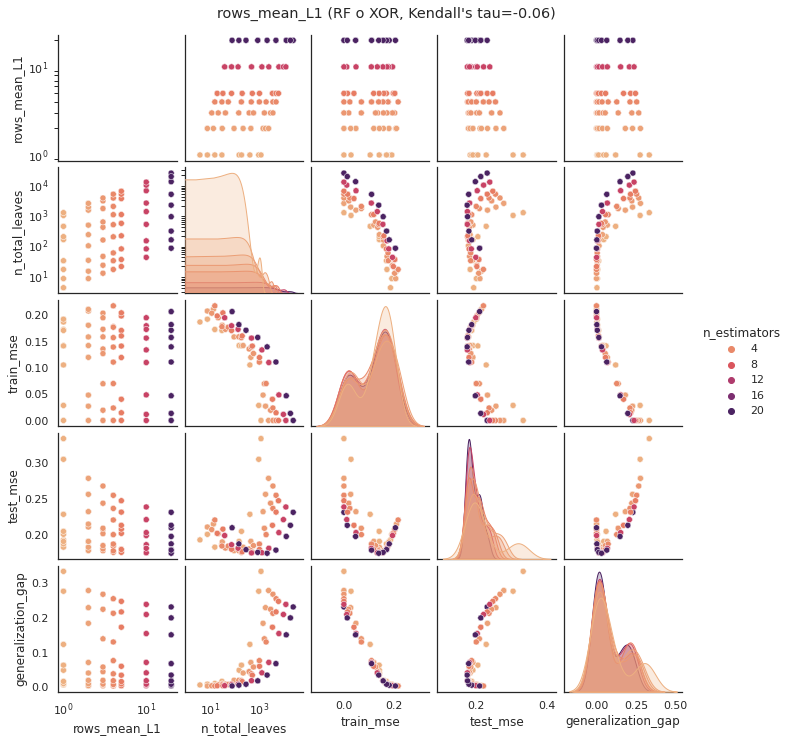

rows_mean_L2
##################################################


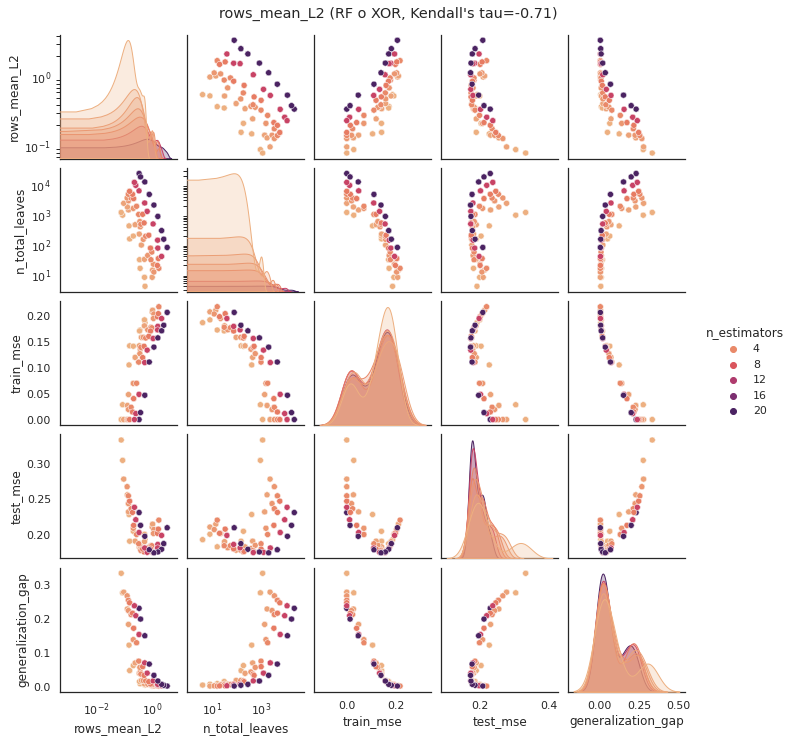

cols_mean_L1
##################################################


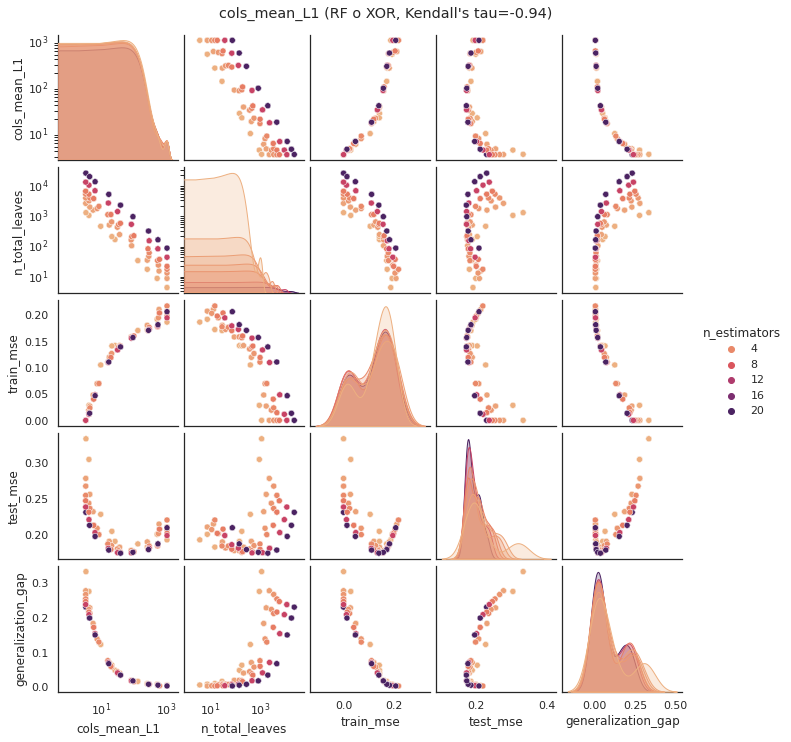

cols_mean_L2
##################################################


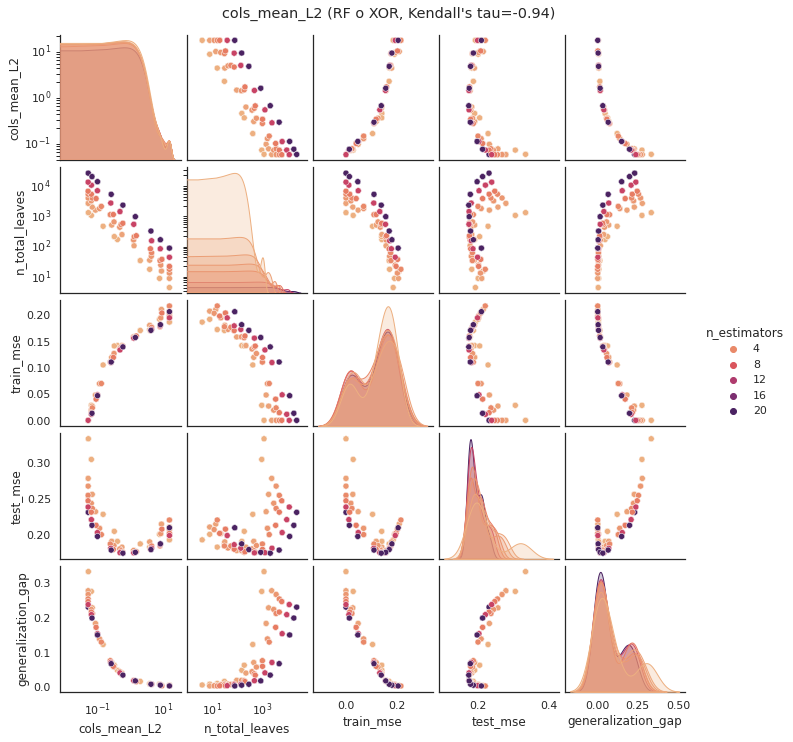

In [7]:
metrics = [
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', # 'entropy',
    'rows_mean_L1', 'rows_mean_L2',
    'cols_mean_L1', 'cols_mean_L2',
]
hue = 'n_estimators'
for metric in metrics:
    print(metric)
    print('#'*50)
    corr, _ = kendalltau(df[metric], df['generalization_gap'])
    variables = [
        metric, 'n_total_leaves', train_error, test_error, 'generalization_gap'
    ]
    g = sns.pairplot(
        df, vars=variables,
        hue=hue,
        palette='flare',
        height=2,
    )
    for ax in [0, 1]:
        g.axes[ax, 0].set_yscale('log')
        g.axes[0, ax].set_xscale('log')
    plt.suptitle(metric + f' (RF o XOR, Kendall\'s tau={corr:.2f})', y=1.02)
    # plt.savefig(f'./figures/rf_{metric}_pairplot.pdf')
    plt.show()

# Network

In [17]:
#
algo = "relu_regressor"
dataset = "xor"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'hidden_layer_dims', 'n_epochs'],
    as_index=False,
).mean()
df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

n_train_samples  hidden_layer_dims  n_epochs  rep  n_test_samples  \
0           1024.0                4.0     500.0  0.0          8192.0   
1           1024.0                8.0     500.0  0.0          8192.0   
2           1024.0               12.0     500.0  0.0          8192.0   
3           1024.0               16.0     500.0  0.0          8192.0   
4           1024.0               24.0     500.0  0.0          8192.0   

   recurse_level  cov_scale  onehot  learning_rate  batch_size  ...  \
0            0.0        1.0     1.0           0.01        32.0  ...   
1            0.0        1.0     1.0           0.01        32.0  ...   
2            0.0        1.0     1.0           0.01        32.0  ...   
3            0.0        1.0     1.0           0.01        32.0  ...   
4            0.0        1.0     1.0           0.01        32.0  ...   

   IRM_rows_mean_L2  IRM_cols_mean_L1  IRM_cols_mean_L2  IRM_mean_dot_product  \
0          1.225920          0.518311          0.016343             96.184387   
1          1.933899          0.563110          0.017773             59.839432   
2          2.179713          0.461751          0.014565             33.785956   
3          2.433799          0.438171          0.013819             23.693516   
4          3.137541          0.472249          0.014794             17.500739   

   IRM_mean_sim_entropy  n_parameters  depth  width  weights_L2  \
0              6.873596            22    1.0    4.0    3.082059   
1              6.918768            42    1.0    8.0    3.791236   
2              6.923105            62    1.0   12.0    4.467567   
3              6.921222            82    1.0   16.0    4.879197   
4              6.926394           122    1.0   24.0    5.225649   

   generalization_gap  
0            0.012857  
1            0.014078  
2            0.015915  
3            0.016448  
4            0.016884  

[5 rows x 36 columns]

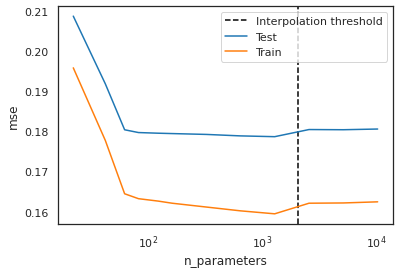

In [18]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(2*df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')

sns.lineplot(
    data=plot_df, x='n_parameters', y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x='n_parameters', y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

In [19]:
corr_vars = [
    'generalization_gap', test_error,
    'n_parameters', 'width',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy', # 'IRM_entropy_normalized',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]
# for hidden_layer_dims in df['hidden_layer_dims'].unique():
# print(hidden_layer_dims)
corr_df = df[corr_vars].corr('spearman')
display(corr_df)
# corr_df.to_csv('./results/dn_spearman_corrs.csv')

generalization_gap  test_mse  n_parameters     width  \
generalization_gap              1.000000 -0.573427      0.867133  0.867133   
test_mse                       -0.573427  1.000000     -0.244755 -0.244755   
n_parameters                    0.867133 -0.244755      1.000000  1.000000   
width                           0.867133 -0.244755      1.000000  1.000000   
IRM_L1                         -0.279720  0.601399     -0.118881 -0.118881   
IRM_L2                          0.496503  0.111888      0.664336  0.664336   
n_regions                       0.881119 -0.300699      0.993007  0.993007   
ACTS_L2                        -0.937063  0.405594     -0.951049 -0.951049   
IRM_h*                         -0.872662  0.226665     -0.872662 -0.872662   
ACTS_h*                        -0.757204  0.407725     -0.757204 -0.757204   
IRM_entropy                    -0.846154  0.223776     -0.979021 -0.979021   
IRM_rows_mean_L2                0.867133 -0.244755      1.000000  1.000000   
IRM_cols_mean_L1               -0.279720  0.601399     -0.118881 -0.118881   
IRM_cols_mean_L2               -0.279720  0.601399     -0.118881 -0.118881   
IRM_mean_dot_product           -0.867133  0.244755     -1.000000 -1.000000   
IRM_mean_sim_entropy            0.860140 -0.237762      0.993007  0.993007   

                        IRM_L1    IRM_L2  n_regions   ACTS_L2    IRM_h*  \
generalization_gap   -0.279720  0.496503   0.881119 -0.937063 -0.872662   
test_mse              0.601399  0.111888  -0.300699  0.405594  0.226665   
n_parameters         -0.118881  0.664336   0.993007 -0.951049 -0.872662   
width                -0.118881  0.664336   0.993007 -0.951049 -0.872662   
IRM_L1                1.000000  0.559441  -0.139860  0.153846  0.135999   
IRM_L2                0.559441  1.000000   0.636364 -0.580420 -0.487331   
n_regions            -0.139860  0.636364   1.000000 -0.965035 -0.872662   
ACTS_L2               0.153846 -0.580420  -0.965035  1.000000  0.872662   
IRM_h*                0.135999 -0.487331  -0.872662  0.872662  1.000000   
ACTS_h*              -0.033284 -0.632390  -0.757204  0.757204  0.701239   
IRM_entropy           0.111888 -0.657343  -0.972028  0.930070  0.819773   
IRM_rows_mean_L2     -0.118881  0.664336   0.993007 -0.951049 -0.872662   
IRM_cols_mean_L1      1.000000  0.559441  -0.139860  0.153846  0.135999   
IRM_cols_mean_L2      1.000000  0.559441  -0.139860  0.153846  0.135999   
IRM_mean_dot_product  0.118881 -0.664336  -0.993007  0.951049  0.872662   
IRM_mean_sim_entropy -0.104895  0.678322   0.986014 -0.944056 -0.846217   

                       ACTS_h*  IRM_entropy  IRM_rows_mean_L2  \
generalization_gap   -0.757204    -0.846154          0.867133   
test_mse              0.407725     0.223776         -0.244755   
n_parameters         -0.757204    -0.979021          1.000000   
width                -0.757204    -0.979021          1.000000   
IRM_L1               -0.033284     0.111888         -0.118881   
IRM_L2               -0.632390    -0.657343          0.664336   
n_regions            -0.757204    -0.972028          0.993007   
ACTS_L2               0.757204     0.930070         -0.951049   
IRM_h*                0.701239     0.819773         -0.872662   
ACTS_h*               1.000000     0.711439         -0.757204   
IRM_entropy           0.711439     1.000000         -0.979021   
IRM_rows_mean_L2     -0.757204    -0.979021          1.000000   
IRM_cols_mean_L1     -0.033284     0.111888         -0.118881   
IRM_cols_mean_L2     -0.033284     0.111888         -0.118881   
IRM_mean_dot_product  0.757204     0.979021         -1.000000   
IRM_mean_sim_entropy -0.765525    -0.993007          0.993007   

                      IRM_cols_mean_L1  IRM_cols_mean_L2  \
generalization_gap           -0.279720         -0.279720   
test_mse                      0.601399          0.601399   
n_parameters                 -0.118881         -0.118881   
width                        -0.118881         -0.118881   
IRM_L1       

IRM_L2
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

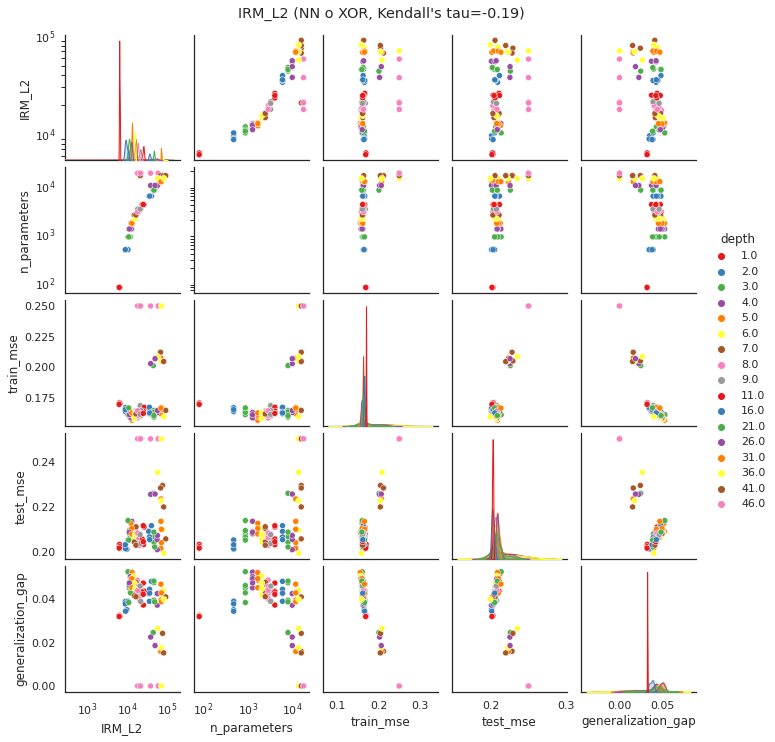

n_regions
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

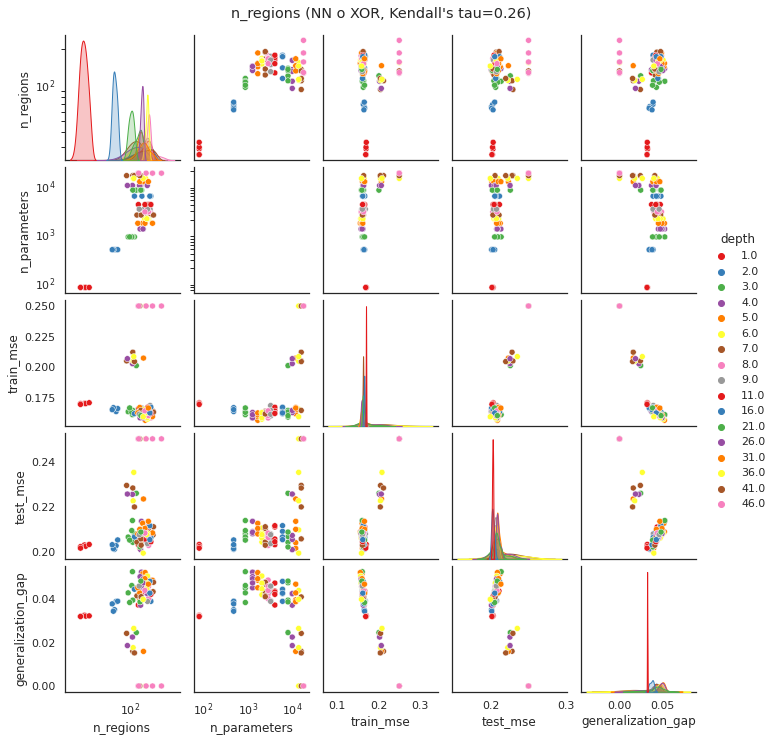

IRM_h*
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

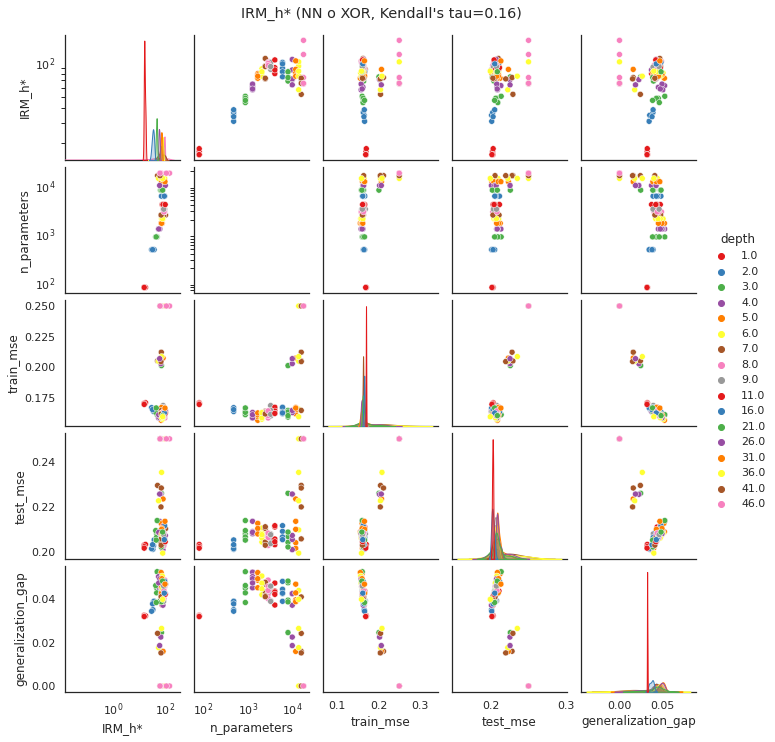

ACTS_h*
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

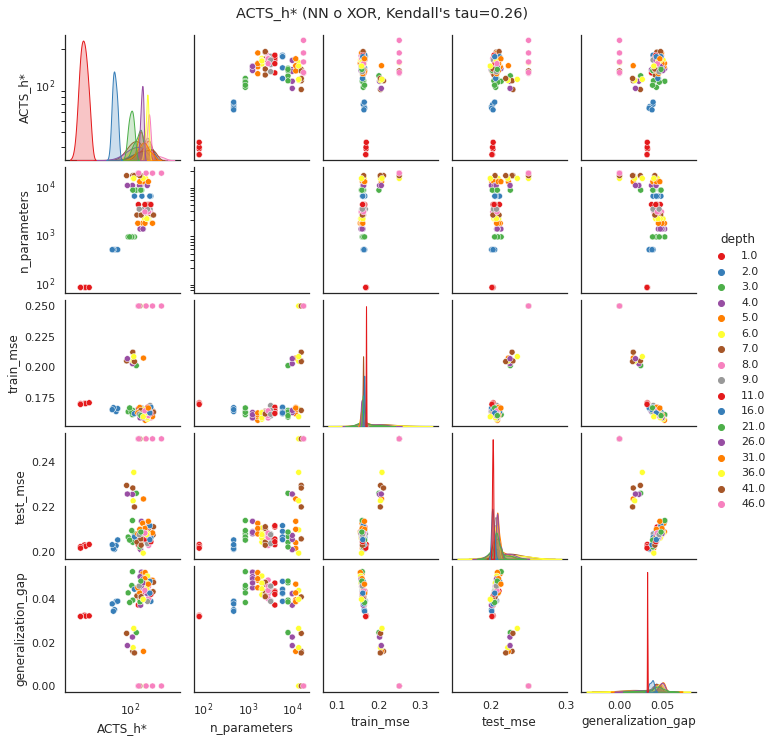

rows_mean_L2
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

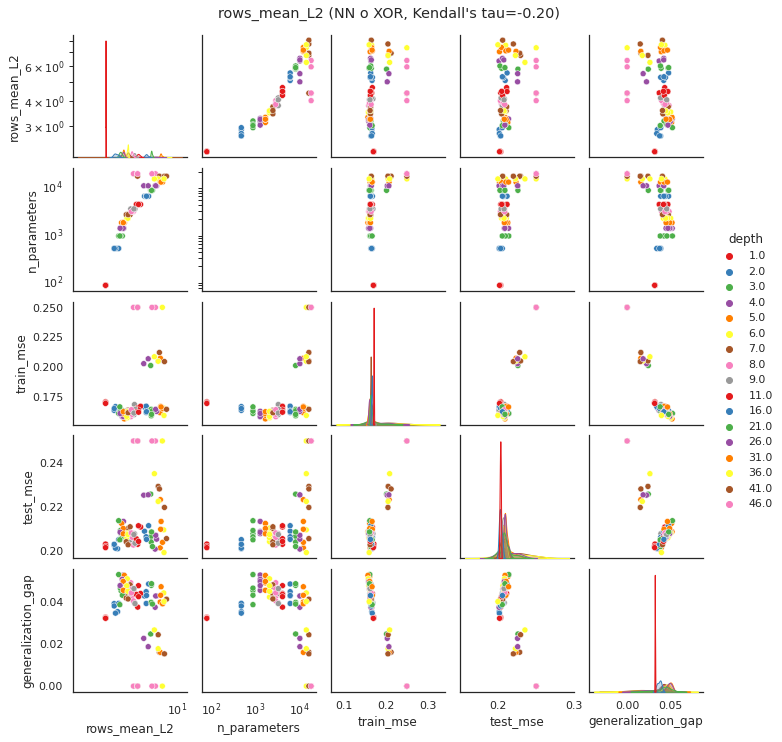

cols_mean_L2
##################################################


/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/mnt/ssd3/

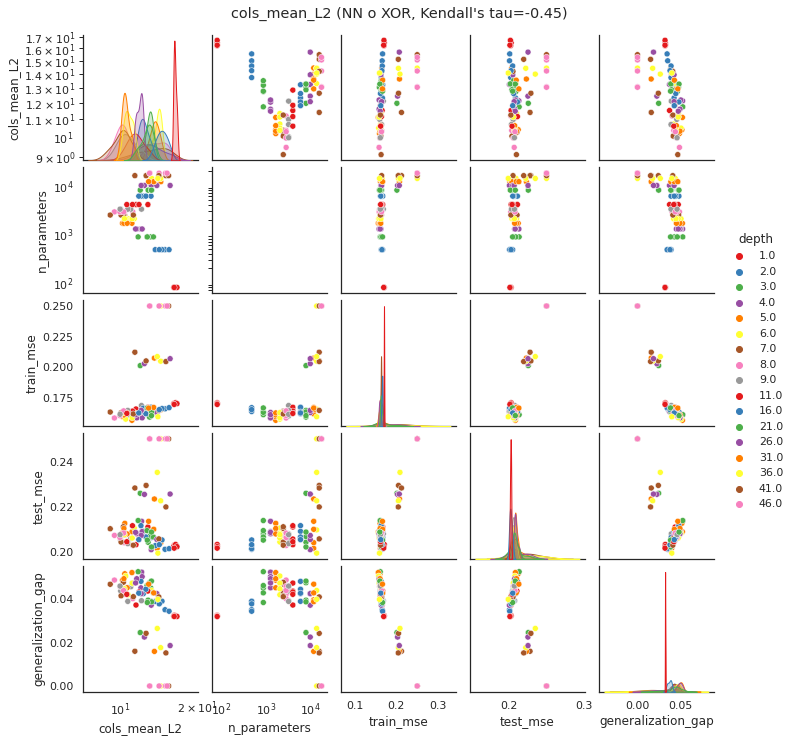

In [6]:
metrics = [
    # 'IRM_L1',
    'IRM_L2',
    'n_regions', # 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', # 'entropy',
    'rows_mean_L2',
    # 'cols_mean_L1',
    'cols_mean_L2',
]
hue = 'depth'
for metric in metrics:
    print(metric)
    print('#'*50)
    corr, _ = kendalltau(df[metric], df['generalization_gap'])
    variables = [
        metric, 'n_parameters', train_error, test_error, 'generalization_gap'
    ]
    g = sns.pairplot(
        df, vars=variables,
        hue=hue,
        palette='Set1',
        height=2,
    )
    for ax in [0, 1]:
        g.axes[ax, 0].set_yscale('log')
        g.axes[0, ax].set_xscale('log')
    plt.suptitle(metric + f' (NN o XOR, Kendall\'s tau={corr:.2f})', y=1.02)
    # plt.savefig(f'./figures/df_{metric}_pairplot.pdf')
    plt.show()

## kNN

In [3]:
#
algo = "knn"
dataset = "xor"

# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'n_neighbors', 'weights'],
    as_index=False,
).mean()
# df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

n_train_samples  n_neighbors   weights  rep  n_test_samples  recurse_level  \
0            100.0          1.0  distance  1.0          8192.0            0.0   
1            100.0          1.0   uniform  1.0          8192.0            0.0   
2            100.0          3.0  distance  1.0          8192.0            0.0   
3            100.0          3.0   uniform  1.0          8192.0            0.0   
4            100.0          5.0  distance  1.0          8192.0            0.0   

   cov_scale  onehot  n_jobs  train_01_error  ...    ACTS_L2  IRM_h*  ACTS_h*  \
0        1.0     1.0    -2.0            0.00  ...  10.000000     0.0      0.0   
1        1.0     1.0    -2.0            0.00  ...  10.000000     0.0      0.0   
2        1.0     1.0    -2.0            0.00  ...  13.190906     0.0      0.0   
3        1.0     1.0    -2.0            0.28  ...  13.190906     0.0      0.0   
4        1.0     1.0    -2.0            0.00  ...  12.569805     0.0      0.0   

   IRM_entropy  IRM_rows_mean_L2  IRM_cols_mean_L1  IRM_cols_mean_L2  \
0     4.605170          0.100000              0.01             0.001   
1     4.605170          0.100000              0.01             0.001   
2     3.831568          0.321248              0.03             0.003   
3     3.831568          0.321248              0.03             0.003   
4     3.587240          0.528583              0.05             0.005   

   IRM_mean_dot_product  IRM_mean_sim_entropy  generalization_gap  
0              1.000000              0.000000            0.393799  
1              1.000000              0.000000            0.393799  
2              1.146667              1.599395            0.248057  
3              1.146667              1.599395            0.069989  
4              1.117600              2.287270            0.223144  

[5 rows x 27 columns]

In [5]:
df[['n_neighbors', 'weights', 'test_01_error', "test_mse"]].head(5)

n_neighbors   weights  test_01_error  test_mse
0          1.0  distance       0.393799  0.393799
1          1.0   uniform       0.393799  0.393799
2          3.0  distance       0.351929  0.248057
3          3.0   uniform       0.335693  0.238878
4          5.0  distance       0.336182  0.223144

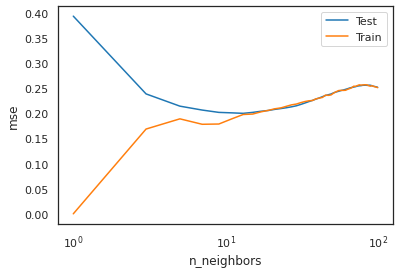

In [6]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df[df['weights'] == 'uniform']
x_var = 'n_neighbors'

fig, ax = plt.subplots(1, 1, sharex=True)

sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

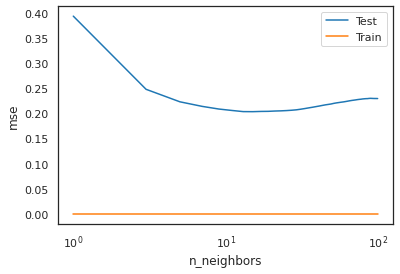

In [7]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df[df['weights'] == 'distance']
x_var = 'n_neighbors'

fig, ax = plt.subplots(1, 1, sharex=True)

sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

In [24]:
corr_vars = [
    'generalization_gap',
    'n_neighbors',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
]
# for hidden_layer_dims in df['hidden_layer_dims'].unique():
# print(hidden_layer_dims)
corr_df = df[corr_vars].corr('spearman')
display(corr_df)
# corr_df.to_csv('./results/dn_spearman_corrs.csv')

generalization_gap  n_neighbors    IRM_L1    IRM_L2  \
generalization_gap            1.000000    -0.700774 -0.700774 -0.700774   
n_neighbors                  -0.700774     1.000000  1.000000  1.000000   
IRM_L1                       -0.700774     1.000000  1.000000  1.000000   
IRM_L2                       -0.700774     1.000000  1.000000  1.000000   
n_regions                     0.455713    -0.647720 -0.647720 -0.647720   
ACTS_L2                      -0.448640     0.642606  0.642606  0.642606   
IRM_h*                        0.477641    -0.527779 -0.527779 -0.527779   
ACTS_h*                       0.396279    -0.588286 -0.588286 -0.588286   
IRM_entropy                  -0.697330     0.998788  0.998788  0.998788   
IRM_rows_mean_L2             -0.700774     1.000000  1.000000  1.000000   
IRM_cols_mean_L1             -0.700774     1.000000  1.000000  1.000000   
IRM_cols_mean_L2             -0.700774     1.000000  1.000000  1.000000   

                    n_regions   ACTS_L2    IRM_h*   ACTS_h*  IRM_entropy  \
generalization_gap   0.455713 -0.448640  0.477641  0.396279    -0.697330   
n_neighbors         -0.647720  0.642606 -0.527779 -0.588286     0.998788   
IRM_L1              -0.647720  0.642606 -0.527779 -0.588286     0.998788   
IRM_L2              -0.647720  0.642606 -0.527779 -0.588286     0.998788   
n_regions            1.000000 -0.995513  0.640524  0.940538    -0.642521   
ACTS_L2             -0.995513  1.000000 -0.628342 -0.936078     0.636893   
IRM_h*               0.640524 -0.628342  1.000000  0.698299    -0.544190   
ACTS_h*              0.940538 -0.936078  0.698299  1.000000    -0.595094   
IRM_entropy         -0.642521  0.636893 -0.544190 -0.595094     1.000000   
IRM_rows_mean_L2    -0.647720  0.642606 -0.527779 -0.588286     0.998788   
IRM_cols_mean_L1    -0.647720  0.642606 -0.527779 -0.588286     0.998788   
IRM_cols_mean_L2    -0.647720  0.642606 -0.527779 -0.588286     0.998788   

                    IRM_rows_mean_L2  IRM_cols_mean_L1  IRM_cols_mean_L2  
generalization_gap         -0.700774         -0.700774         -0.700774  
n_neighbors                 1.000000          1.000000          1.000000  
IRM_L1                      1.000000          1.000000          1.000000  
IRM_L2                      1.000000          1.000000          1.000000  
n_regions                  -0.647720         -0.647720         -0.647720  
ACTS_L2                     0.642606          0.642606          0.642606  
IRM_h*                     -0.527779         -0.527779         -0.527779  
ACTS_h*                    -0.588286         -0.588286         -0.588286  
IRM_entropy                 0.998788          0.998788          0.998788  
IRM_rows_mean_L2            1.000000          1.000000          1.000000  
IRM_cols_mean_L1            1.000000          1.000000          1.000000  
IRM_cols_mean_L2            1.000000          1.000000          1.000000

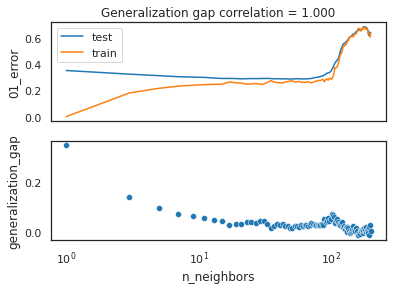

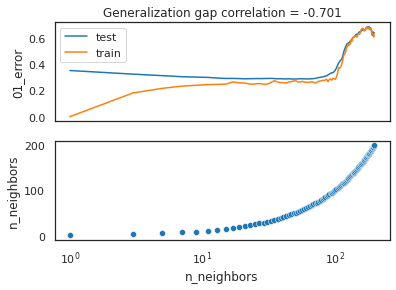

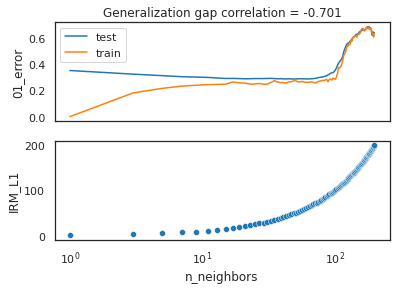

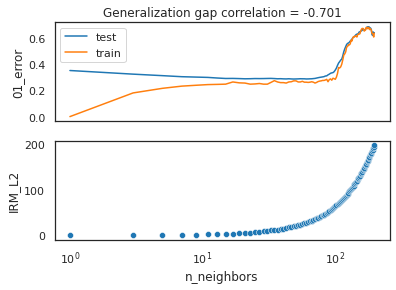

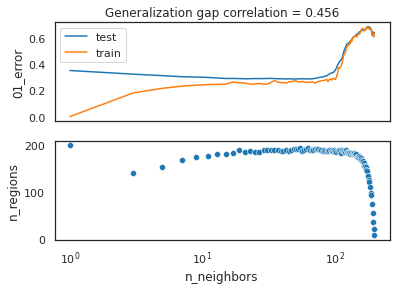

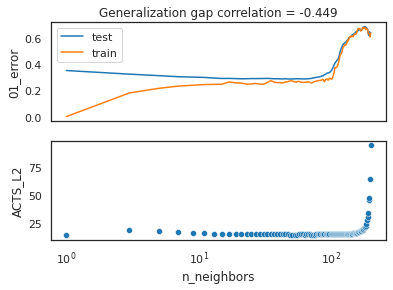

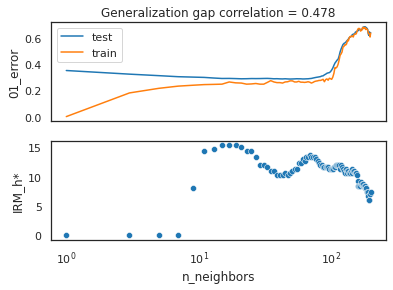

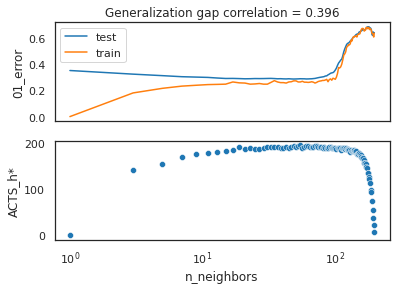

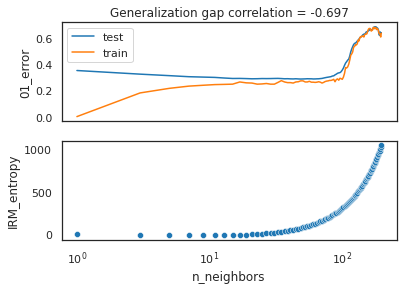

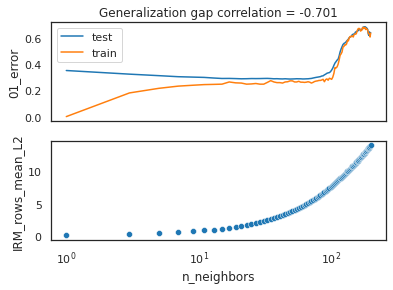

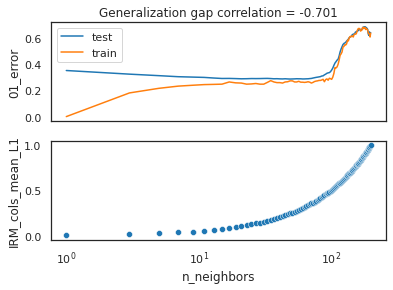

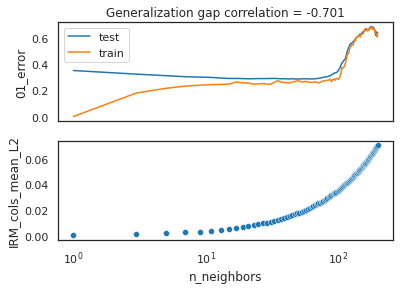

In [25]:
plot_vars = [
    'generalization_gap',
    'n_neighbors',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
]

x_var = 'n_neighbors'

for var in plot_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        
    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.scatterplot(
        data=df, x=x_var, y=var,
        ax=ax2)

    plt.xscale('log')
    # plt.yscale('symlog')#, linthresh=1e-3)
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_ylabel(metric)
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    ax1.legend()
    plt.show()

## Random relu features

In [8]:
#
algo = "rrf"
dataset = "xor"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'out_features'],
    as_index=False,
).mean()
# df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

n_train_samples  out_features  rep  n_test_samples  recurse_level  \
0            512.0           4.0  1.0          8192.0            0.0   
1            512.0           5.0  1.0          8192.0            0.0   
2            512.0           6.0  1.0          8192.0            0.0   
3            512.0           7.0  1.0          8192.0            0.0   
4            512.0           8.0  1.0          8192.0            0.0   

   cov_scale  onehot  train_01_error  train_mse  test_01_error  ...  \
0        0.3     1.0        0.399089   0.219602       0.406698  ...   
1        0.3     1.0        0.233073   0.196727       0.248698  ...   
2        0.3     1.0        0.203125   0.142198       0.213135  ...   
3        0.3     1.0        0.145182   0.116189       0.145671  ...   
4        0.3     1.0        0.180990   0.137171       0.183187  ...   

       IRM_L2  n_regions     ACTS_L2    IRM_h*   ACTS_h*  IRM_entropy  \
0  142.109429   2.666667  451.333384  2.000000  2.666667   717.371182   
1  315.237853   3.666667  379.730482  3.666667  3.666667  1883.984944   
2  210.226788   5.333333  308.897413  5.333333  5.333333  1254.111018   
3  269.800068   5.000000  286.529893  5.000000  5.000000  1614.608324   
4  189.831489   4.666667  318.926731  4.333333  4.666667  1049.126127   

   IRM_rows_mean_L2  IRM_cols_mean_L1  IRM_cols_mean_L2  generalization_gap  
0          1.008089          0.288086          0.013428            0.007609  
1          1.732179          0.664323          0.029601            0.015625  
2          1.496961          0.490885          0.022687            0.010010  
3          1.881805          0.600725          0.027271            0.000488  
4          1.690819          0.412923          0.018595            0.002197  

[5 rows x 23 columns]

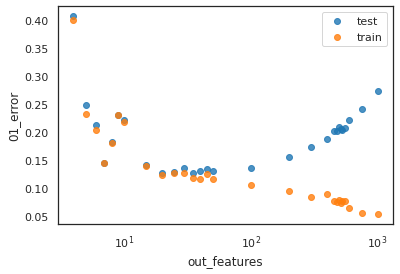

In [9]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df# [(df['hidden_layer_dims'] >= 38) & (df['hidden_layer_dims'] <= 64)]

fig, ax = plt.subplots(1, 1, sharex=True)
x_var = 'out_features' # 'n_parameters'

sns.regplot(
    data=plot_df, x=x_var, y=test_error, lowess=False,
    ax=ax, label='test', fit_reg=False, x_ci=90)
sns.regplot(
    data=plot_df, x=x_var, y=train_error, lowess=False,
    ax=ax, label='train', fit_reg=False, x_ci=90)

plt.xscale('log')
plt.ylabel(metric)
# plt.yscale('symlog')
plt.legend()
plt.show()

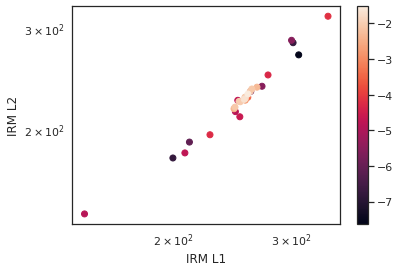

In [10]:
fig, ax = plt.subplots(1, 1)
sc = ax.scatter(df['IRM_L1'], df['IRM_L2'], c=np.log(df['generalization_gap']))
ax.set_xlabel('IRM L1')
ax.set_ylabel('IRM L2')
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(sc)
plt.show()

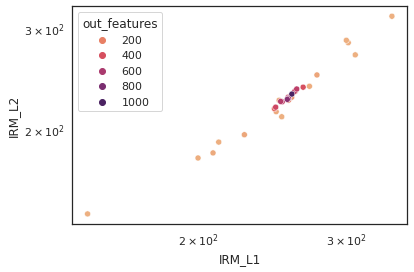

In [11]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df, x='IRM_L1', y='IRM_L2', hue='out_features', ax=ax, palette='flare')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [12]:
corr_vars = [
    'generalization_gap', test_error,
    'out_features',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
]
# for hidden_layer_dims in df['hidden_layer_dims'].unique():
# print(hidden_layer_dims)
corr_df = df[corr_vars].corr('spearman')
display(corr_df)
# corr_df.to_csv('./results/dn_spearman_corrs.csv')

generalization_gap  test_01_error  out_features    IRM_L1  \
generalization_gap            1.000000       0.410565      0.885605 -0.010947   
test_01_error                 0.410565       1.000000      0.146982  0.146709   
out_features                  0.885605       0.146982      1.000000 -0.020799   
IRM_L1                       -0.010947       0.146709     -0.020799  1.000000   
IRM_L2                        0.014778       0.149993      0.033388  0.979201   
n_regions                     0.896797       0.155647      0.994251 -0.015330   
ACTS_L2                      -0.893815      -0.125633     -0.970991  0.031746   
IRM_h*                        0.471218      -0.408225      0.609924 -0.091009   
ACTS_h*                       0.896797       0.155647      0.994251 -0.015330   
IRM_entropy                  -0.026820       0.145614     -0.032293  0.990695   
IRM_rows_mean_L2              0.888889       0.160394      0.995074  0.045977   
IRM_cols_mean_L1             -0.010947       0.146709     -0.020799  1.000000   
IRM_cols_mean_L2             -0.066776       0.159573     -0.128079  0.969349   

                      IRM_L2  n_regions   ACTS_L2    IRM_h*   ACTS_h*  \
generalization_gap  0.014778   0.896797 -0.893815  0.471218  0.896797   
test_01_error       0.149993   0.155647 -0.125633 -0.408225  0.155647   
out_features        0.033388   0.994251 -0.970991  0.609924  0.994251   
IRM_L1              0.979201  -0.015330  0.031746 -0.091009 -0.015330   
IRM_L2              1.000000   0.028470  0.003284 -0.067434  0.028470   
n_regions           0.028470   1.000000 -0.977279  0.620648  1.000000   
ACTS_L2             0.003284  -0.977279  1.000000 -0.601152 -0.977279   
IRM_h*             -0.067434   0.620648 -0.601152  1.000000  0.620648   
ACTS_h*             0.028470   1.000000 -0.977279  0.620648  1.000000   
IRM_entropy         0.989053  -0.029291  0.053640 -0.093476 -0.029291   
IRM_rows_mean_L2    0.103448   0.989598 -0.967159  0.605264  0.989598   
IRM_cols_mean_L1    0.979201  -0.015330  0.031746 -0.091009 -0.015330   
IRM_cols_mean_L2    0.921730  -0.112510  0.119321 -0.152687 -0.112510   

                    IRM_entropy  IRM_rows_mean_L2  IRM_cols_mean_L1  \
generalization_gap    -0.026820          0.888889         -0.010947   
test_01_error          0.145614          0.160394          0.146709   
out_features          -0.032293          0.995074         -0.020799   
IRM_L1                 0.990695          0.045977          1.000000   
IRM_L2                 0.989053          0.103448          0.979201   
n_regions             -0.029291          0.989598         -0.015330   
ACTS_L2                0.053640         -0.967159          0.031746   
IRM_h*                -0.093476          0.605264         -0.091009   
ACTS_h*               -0.029291          0.989598         -0.015330   
IRM_entropy            1.000000          0.036125          0.990695   
IRM_rows_mean_L2       0.036125          1.000000          0.045977   
IRM_cols_mean_L1       0.990695          0.045977          1.000000   
IRM_cols_mean_L2       0.961138         -0.067871          0.969349   

                    IRM_cols_mean_L2  
generalization_gap         -0.066776  
test_01_error               0.159573  
out_features               -0.128079  
IRM_L1                      0.969349  
IRM_L2                      0.921730  
n_regions                  -0.112510  
ACTS_L2                     0.119321  
IRM_h*                     -0.152687  
ACTS_h*                    -0.112510  
IRM_entropy                 0.961138  
IRM_rows_mean_L2           -0.067871  
IRM_cols_mean_L1            0.969349  
IRM_cols_mean_L2            1.000000